#### Text Classification: Multiclass

This is a continuation of the previous notebook, but without a tutorial as an extra assignment. MultiClass classification on Stack Overflow data

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers, losses

2023-12-15 11:09:54.193072: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 11:09:54.220357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 11:09:54.220387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 11:09:54.221113: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 11:09:54.226400: I tensorflow/core/platform/cpu_feature_guar

In [3]:
DATAPTH = '../data'
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("so_16k", url, untar=True, cache_dir=DATAPTH, cache_subdir='so_16k')


In [4]:
dataset_dir = os.path.join(os.path.dirname(dataset))
os.listdir(dataset_dir)

['train', 'test', 'so_16k.tar.gz', 'README.md']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['javascript', 'python', 'csharp', 'java']

In [6]:
sample_file = os.path.join(train_dir, 'java/100.txt')
with open(sample_file) as f:
    print(f.read())

"how many objects are created in inheritance? if only one then how parent class constructor gets executed when sub class object is create....class parent.{. parent(). {.  system.out.println(""parent class construcor"");. }.}.class child extends parent .{. child(). {.  system.out.println(""child class construcor"");. }. .}. class test. {.  public static void main(string a[]).  {.   child obj = new child();.  }. }"



In [7]:
batch_size = 32
seed = 1234

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    DATAPTH + '/so_16k/train',
    batch_size=batch_size,
    validation_split = 0.2,
    subset='training',
    seed = seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2023-12-15 11:10:00.926320: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 11:10:00.951565: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 11:10:00.951604: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 11:10:00.953998: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 11:10:00.954037: I external/local_xla/xla/stream_executor

In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(10):
        print("Review", text_batch.numpy()[i])
        print('Label', label_batch.numpy()[i])

Review b'"the recursive method is getting into deadloop i am writing a simple crawler based on htmlagilitypack and fizzler, in order to check if a keyword is contained anywhere on the webpage and it\'s corresponding sublinks. then the same procedure is repeated for all of the sublinks up to 50 level deep. so that the number grows exponentially. ..the issue is that i wanted to convert the method that i have written to a recursive one, but it doesn\'t work - gets stuck after first link, as well as works really slow...this is what i\'ve done currently:..    public static void getalllinks(htmlweb web, list&lt;string&gt; relevantlinks, string inputlink).    {.        string mainlink = ""http://www.cnet.com"";.        console.writeline(""current count of links: "" + relevantlinks.count + ""tcurrent link: "" + inputlink);...        htmldocument html = web.load(inputlink);.        htmldocument htmlinner = new htmldocument();..        html.documentnode.descendants().            .where(n =&gt; n

In [9]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    DATAPTH + '/so_16k/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [10]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    DATAPTH + '/so_16k/test',
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


In [11]:
# This dataset shouldn't have HTML tags, but I'll copy the code anyway

def custom_standardization(input_data):
    lower = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lower, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [12]:
max_features = 15000
sequence_length = 300

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [13]:
train_text = raw_train_ds.map(lambda x,y: x)
vectorize_layer.adapt(train_text)

In [14]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [15]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print('Review', first_review)
print('Label', raw_train_ds.class_names[first_label])
print('Vectorized Review', vectorize_text(first_review, first_label))

Review tf.Tensor(b'"how to use regex to format a number as 2.5k in a string to 2.5e3 i am parsing a spice file with blank which contains string math expressions and i am converting the text file to a blank script...an example of a math expressions in the file is:..expr = \'k1 + 4.35k + 3.69meg*(pow(2.4u, 2*km2))\'...i would like to find all the scaling factors in the expression and convert them to their exponent values:..scaling_factors = {.    \'g\'  : \'e9\',.    \'meg\': \'e6\',.    \'k\'  : \'e3\',.    \'m\'  : \'e-3\',.    \'u\'  : \'e-6\',.    \'n\'  : \'e-9\',.}...my wanted output would be like:..converted_expr = \'k1 + 4.35e3 + 3.69e6*(pow(2.4e-6, 2*km2))\'...i tried this:..digits_re = r""([0-9]*.[0-9]+|[0-9]+)k"".sample = \'k1 + 4.3k\'.print(re.sub(digits_re, digits_re.replace(\'k\', \'e3\'), sample))...output:..k1 + \\de3...but it doesn\'t work"\n', shape=(), dtype=string)
Label python
Vectorized Review (<tf.Tensor: shape=(1, 300), dtype=int64, numpy=
array([[   25,     4,   

In [16]:
for i in range(250):
    item = vectorize_text(first_review, first_label)[0][0][i]
    value = tf.keras.backend.get_value(item)
    if value == 0:
        continue
    print(value, " --->", vectorize_layer.get_vocabulary()[value])
print('Vocabulary Size: ', len(vectorize_layer.get_vocabulary()))


25  ---> how
4  ---> to
69  ---> use
1111  ---> regex
4  ---> to
296  ---> format
5  ---> a
66  ---> number
36  ---> as
1  ---> [UNK]
7  ---> in
5  ---> a
18  ---> string
4  ---> to
1  ---> [UNK]
3  ---> i
35  ---> am
1113  ---> parsing
5  ---> a
1  ---> [UNK]
40  ---> file
22  ---> with
16  ---> blank
68  ---> which
288  ---> contains
18  ---> string
1057  ---> math
1954  ---> expressions
8  ---> and
3  ---> i
35  ---> am
924  ---> converting
2  ---> the
118  ---> text
40  ---> file
4  ---> to
5  ---> a
16  ---> blank
1  ---> [UNK]
138  ---> example
9  ---> of
5  ---> a
1057  ---> math
1954  ---> expressions
7  ---> in
2  ---> the
40  ---> file
1  ---> [UNK]
4636  ---> k1
1  ---> [UNK]
1  ---> [UNK]
1  ---> [UNK]
65  ---> would
48  ---> like
4  ---> to
141  ---> find
72  ---> all
2  ---> the
9077  ---> scaling
3475  ---> factors
7  ---> in
2  ---> the
652  ---> expression
8  ---> and
218  ---> convert
185  ---> them
4  ---> to
349  ---> their
5257  ---> exponent
1  ---> [UNK]
552  ---

In [17]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [18]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [19]:
embedding_dim = 64
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim), # takes integer encoded reviews and looks ip and embedding vector for each word-index
    layers.Dropout(0.2),
    layers.SeparableConv1D(filters=32,
                           kernel_size=3,
                           activation='relu',
                           padding='same'),
    layers.SeparableConv1D(filters=32,
                           kernel_size=3,
                           activation='relu',
                           padding='same'),
    layers.GlobalAveragePooling1D(), # returns fixed length ouput vector for each example by averaging over the sequence dimension
    layers.Dropout(0.2),
    layers.Dense(4)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          960000    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 separable_conv1d (Separabl  (None, None, 32)          2272      
 eConv1D)                                                        
                                                                 
 separable_conv1d_1 (Separa  (None, None, 32)          1152      
 bleConv1D)                                                      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                        

In [20]:
callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3)]
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [21]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/50


2023-12-15 11:10:08.649120: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-15 11:10:08.757421: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-15 11:10:09.275201: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3448fd3d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-15 11:10:09.275231: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2023-12-15 11:10:09.279022: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702667409.346102  282351 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 19s 82ms/step - loss: 1.3863 - accuracy: 0.2448 - val_loss: 1.3862 - val_accuracy: 0.2488
Epoch 2/50
200/200 [==============================] - 9s 46ms/step - loss: 1.3862 - accuracy: 0.2541 - val_loss: 1.3860 - val_accuracy: 0.2606
Epoch 3/50
200/200 [==============================] - 6s 30ms/step - loss: 1.3857 - accuracy: 0.2764 - val_loss: 1.3852 - val_accuracy: 0.3244
Epoch 4/50
200/200 [==============================] - 4s 20ms/step - loss: 1.3835 - accuracy: 0.2941 - val_loss: 1.3815 - val_accuracy: 0.3450
Epoch 5/50
200/200 [==============================] - 3s 16ms/step - loss: 1.3738 - accuracy: 0.3380 - val_loss: 1.3660 - val_accuracy: 0.3631
Epoch 6/50
200/200 [==============================] - 3s 15ms/step - loss: 1.3425 - accuracy: 0.3752 - val_loss: 1.3261 - val_accuracy: 0.3887
Epoch 7/50
200/200 [==============================] - 3s 13ms/step - loss: 1.2877 - accuracy: 0.4039 - val_loss: 1.2696 - val_accuracy: 0.4081
Epoch 8/5

No matter what I do in this simple paradigm, I'm stuck at around 76% validation accuracy. There's some obvious overfitting going on here that I can't seem to overcome

In [22]:
loss, accuracy = model.evaluate(test_ds)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

  1/250 [..............................] - ETA: 12s - loss: 0.8455 - accuracy: 0.6562

250/250 [==============================] - 1s 4ms/step - loss: 0.8521 - accuracy: 0.6441
Loss:  0.8521233201026917
Accuracy:  0.6441249847412109


In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

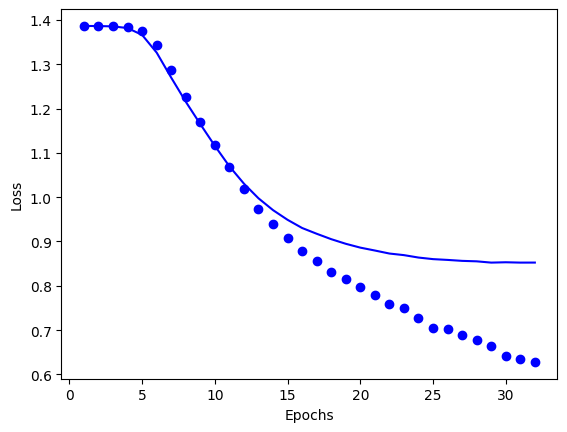

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

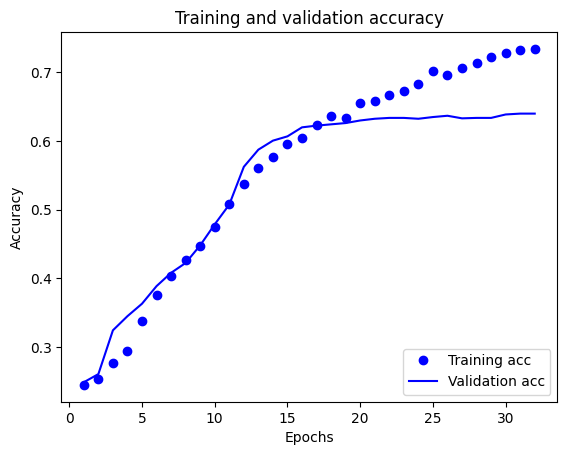

In [25]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()